In [1]:
import pandas as pd 
df = pd.read_csv('../data/processed/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [2]:
df['loan_status'] = df['loan_status'].replace({0:'non_defualt', 1:'defualt'})
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = df[i].astype('category')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,non_defualt,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,defualt,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,defualt,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,defualt,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,defualt,0.25,N,2


In [3]:
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower, upper=upper)
    return df

In [ ]:
clean_df = df.copy()
num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length'
]
for col in num_cols:
    clean_df = cap_outliers_iqr(clean_df, col)
    # print(len(clean_df))

28632
28632
28632
28632
28632
28632
28632


In [50]:
df_cluster = clean_df.drop(columns=['loan_status', 'loan_grade'])
num_cols = df_cluster.select_dtypes(include=['int64', 'float64']).columns
# num_cols = [
#     'person_income', 'person_emp_length',
#     'loan_amnt', 'loan_int_rate'
# ]
cat_cols = df_cluster.select_dtypes(include=['object', 'category']).columns

In [51]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat = encoder.fit_transform(df_cluster[cat_cols])

scaler = StandardScaler()
scaled_num = scaler.fit_transform(df_cluster[num_cols])

X = np.hstack((scaled_num, encoded_cat))
# X = scaled_num

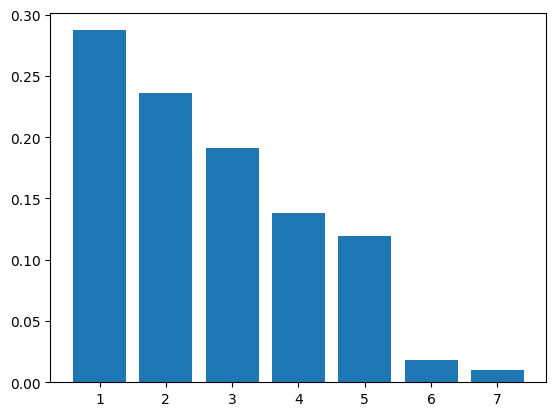

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
df_pca = pca.fit_transform(scaled_num)

plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.show()

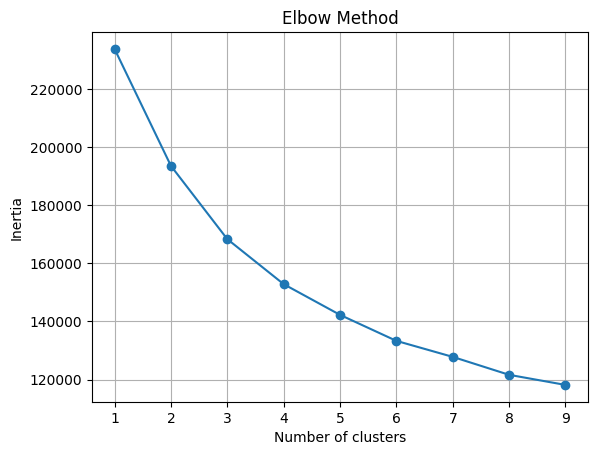

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

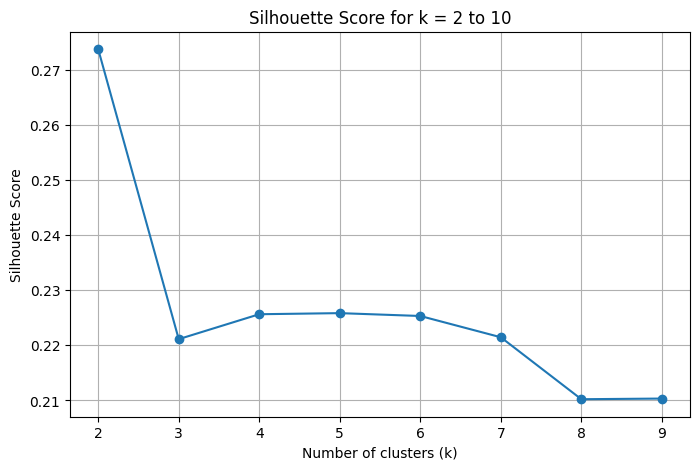

In [37]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)
plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k = 2 to 10')
plt.grid(True)
plt.show()

In [38]:
sil_scores

[0.2737257196265256,
 0.22112852056775617,
 0.2256485594206034,
 0.22584766953667348,
 0.22532977690724848,
 0.22147086988615994,
 0.210229789939081,
 0.2103500040568638]

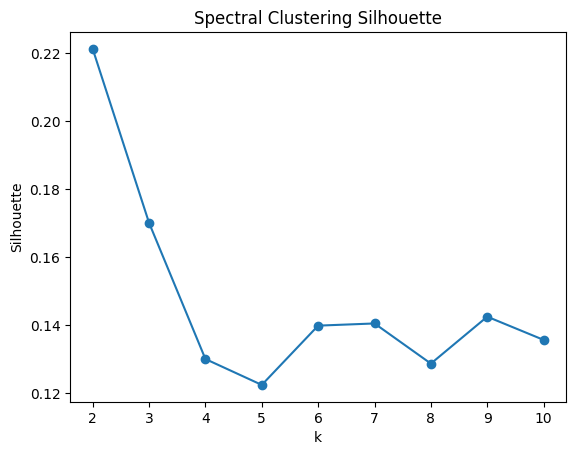

In [17]:
from sklearn.cluster import SpectralClustering

scores = []
K = range(2, 11)

for k in K:
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        n_neighbors=10,
        random_state=42
    )
    labels = spectral.fit_predict(X)
    scores.append(silhouette_score(X, labels))

plt.plot(K, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Spectral Clustering Silhouette')
plt.show()


In [48]:
from sklearn.cluster import SpectralClustering

kmeans = KMeans(n_clusters=2, random_state=42)
k_clusters = kmeans.fit_predict(X)

spectral = SpectralClustering(
        n_clusters=2,
        affinity='nearest_neighbors',
        n_neighbors=10,
        random_state=42
    )
s_clusters = spectral.fit_predict(X)

sc = silhouette_score(X, s_clusters)
sc
# clean_df['k_clusters'] = k_clusters
# clean_df['s_clusters'] = s_clusters

-0.06831949260282247

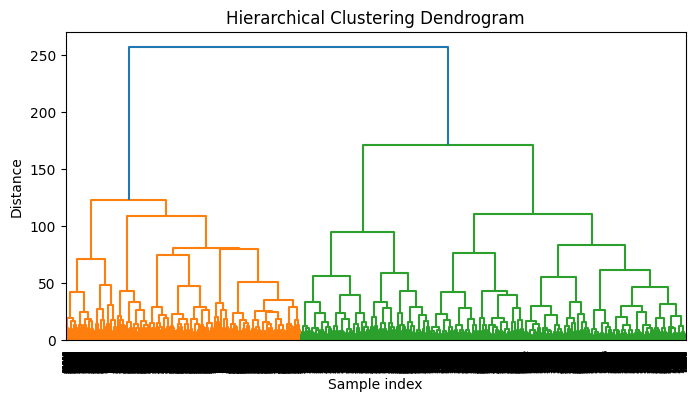

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(X, 'ward')

# Plot dendrogram (tree)
plt.figure(figsize=(8, 4))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.xticks([])
plt.ylabel('Distance')
plt.show()

In [52]:
from scipy.cluster.hierarchy import fcluster

max_distance = 100

# Get cluster labels
clusters = fcluster(linked, t=max_distance, criterion='distance')
print(f'Cluster labels when cutting at distance {max_distance}:')
print(clusters)

# How many clusters?
num_clusters = len(set(clusters))
print(f'Number of clusters: {num_clusters}')

NameError: name 'linked' is not defined

In [53]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,      # number of clusters
    covariance_type='full',
    random_state=42
)

gmm.fit(X)
labels = gmm.predict(X)
print(labels)
print(f'Bic: {gmm.bic(X)}')
print(f'Aic: {gmm.aic(X)}')

[1 2 2 ... 0 2 2]
Bic: -791301.7338374298
Aic: -795085.85819305


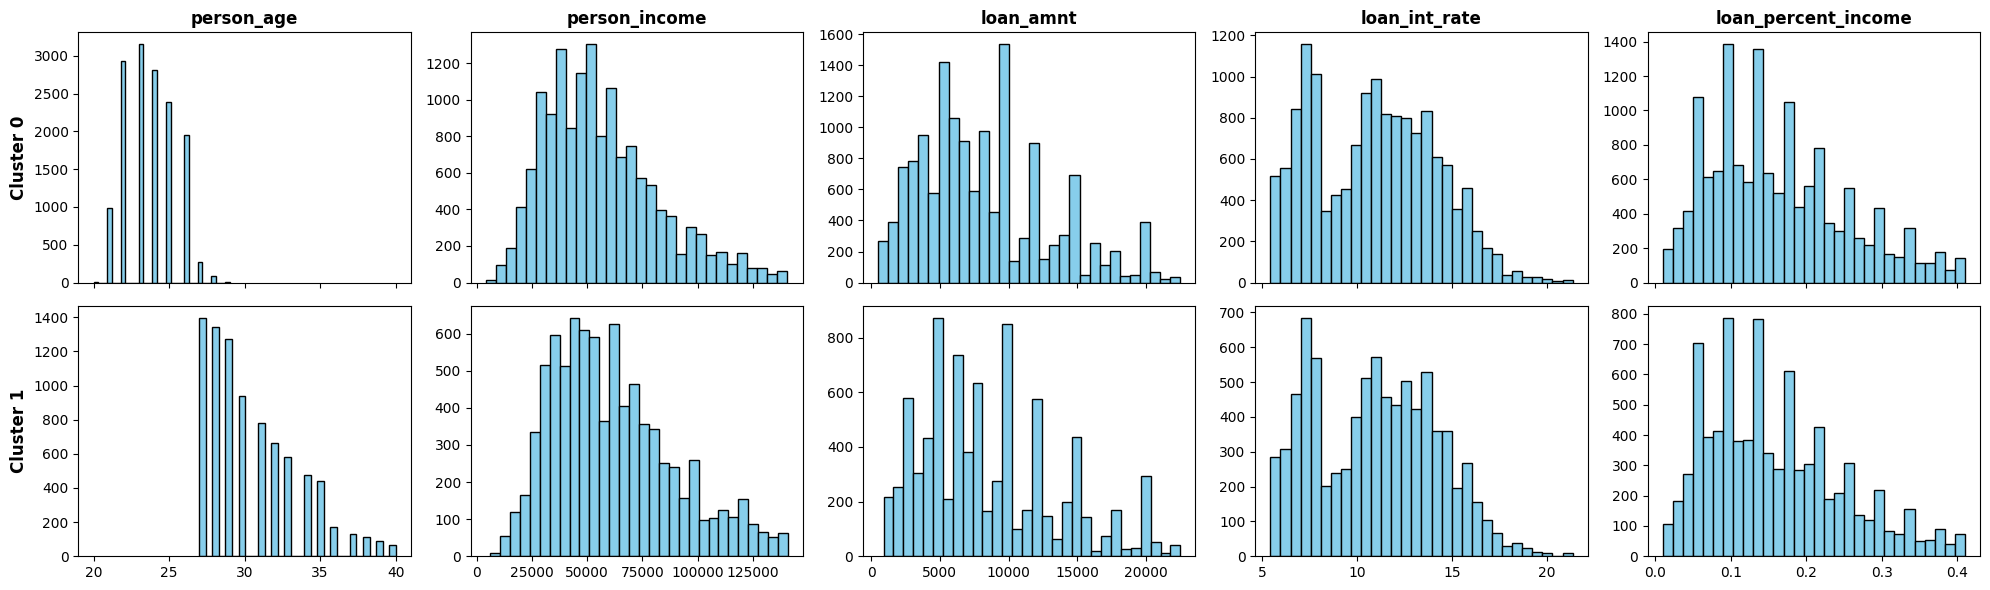

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your features
num_cols = [
    'person_age',
    'person_income',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income'
]

cat_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

all_cols = num_cols

clusters = sorted(clean_df['k_clusters'].unique())
n_clusters = len(clusters)
n_features = len(all_cols)

fig, axes = plt.subplots(n_clusters, n_features, figsize=(4*n_features, 3*n_clusters), sharex='col')

for row_idx, cluster in enumerate(clusters):
    df_cluster = clean_df[clean_df['k_clusters'] == cluster]
    
    for col_idx, feature in enumerate(all_cols):
        ax = axes[row_idx, col_idx] if n_clusters > 1 else axes[col_idx]
        
        if feature in num_cols:
            ax.hist(df_cluster[feature], bins=30, color='skyblue', edgecolor='black')
            ax.set_ylabel('Count' if col_idx == 0 else '')
        else:  # categorical
            sns.countplot(x=feature, data=df_cluster, ax=ax)
            ax.set_ylabel('Count' if col_idx == 0 else '')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        if row_idx == 0:
            ax.set_title(feature, fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f'Cluster {cluster}', fontsize=12, fontweight='bold')
        
        # Clean up x-labels for non-bottom plots
        if row_idx < n_clusters - 1:
            ax.set_xlabel('')
            if feature in cat_cols:
                ax.set_xticklabels([])

plt.tight_layout()
plt.show()